In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Project 2. Due by Saturday, February 17. ##

For this project we will use the **NYISO Data**.

Throughout, we will compute the length of a link as computed using the latitude and longitude of each node (termed 'bus' in the data set).

1. Repeat one million times: take a randomly chosen pair of nodes A and B, and compute the length of a shortest path between them. You can use any library for this purpose. Plot a histogram showing the distribution of lengths.

2. Implement the algorithm for the minimum-cost node tour problem (i.e., the node inspection problem) on this data.  You only need to examine **one** pairing of the odd nodes. You only need to report on the **cost** of your tour.

3. Now repeat step 2, examining *random* pairings of the odd nodes.  Perform this step for at least 1000 pairings.  The TA/CA may ask to perform more.  Report on the best solution you find.

4. Extra credit (**only do this if 1-3 are 100% completed**).  Use the 'splicing' algorithm to actually compute the tour itself, for the best solution obtained in Step 3.


## Import Packages

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import random
import networkx as nx
from geopy.distance import great_circle, geodesic
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

## Data Cleaning

In [29]:
data_dir = '/content/drive/My Drive/Spring_2024/IEOR4004/Data/NewYorkElectricGrid/'
buses = pd.read_csv(data_dir+'nyisobuses.csv', skiprows=1, index_col=[0])
branches = pd.read_csv(data_dir+'nyisobranches.csv')

In [30]:
buses.head()

,Name,Area Name,Latitude,Longitude,Status,# Neighbors (in service only),Nom kV,PU Volt,Volt (kV),Angle (Deg),...,Gen Min MW,Gen Max MW,Gen Min Mvar,Gen Max Mvar,Switched Shunts Mvar,Switched Shunts Nom Mvar,Max Mvar,Min Mvar,Area Num,Zone Num
Number,,,,,,,,,,,,,,,,,,,,,
123,J C McNeil,Vermont,44.492,-73.208,Connected,1,138.0,0.99773,137.686,-46.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,1
187,9001043100,Connecticut,41.110,-73.457,Connected,1,138.0,0.99500,137.310,-124.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
239,9001071000,Connecticut,41.172,-73.218,Connected,1,230.0,1.00859,231.975,-115.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
338,9001245500,Connecticut,41.275,-73.516,Connected,1,138.0,0.95884,132.319,-122.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
845,9011690300,Connecticut,41.293,-72.925,Connected,1,138.0,0.98595,136.062,-118.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1


In [31]:
nan_indices_buses = buses.index[buses['Latitude'].isna()].to_list()
nan_indices_buses += buses.index[buses['Longitude'].isna()].to_list()
duplicate_indices_buses = buses.index[buses.duplicated(subset = ['Name'], keep = False)].to_list()
print(buses.loc[nan_indices_buses, 'Name'])
print(buses.loc[duplicate_indices_buses, 'Name'])

Series([], Name: Name, dtype: object)
Number
3362                        50007002200
3502                     Indian Point 2
3503                     Indian Point 3
3504                Oswego Harbor Power
3505                    Charles Poletti
                      ...              
77626    PSEG Linden Generating Station
77627    PSEG Linden Generating Station
77635         Bergen Generating Station
78036                       34017010800
78955                       42069110600
Name: Name, Length: 209, dtype: object


In [32]:
duplicate_dict_buses = {}
first_appear_buses = {}
for index in duplicate_indices_buses:
    name = buses.loc[index, 'Name']
    if name not in first_appear_buses.keys():
        first_appear_buses[name] = index
    else:
        duplicate_dict_buses[index] = first_appear_buses[name]
print(duplicate_dict_buses)
print(first_appear_buses)

{76428: 3362, 76453: 3502, 76454: 3503, 76455: 3503, 76456: 3504, 76457: 3505, 76458: 3506, 76460: 3507, 76462: 3508, 76463: 3509, 76464: 3509, 76466: 3510, 76467: 3510, 76470: 3512, 76472: 3513, 76473: 3513, 76475: 3514, 76476: 3515, 76478: 3516, 76479: 3517, 76483: 3520, 76484: 3520, 76485: 3521, 76487: 3522, 76488: 3523, 76490: 3524, 76491: 3525, 76492: 3525, 76493: 3526, 76496: 3528, 76497: 3528, 76509: 3542, 76514: 3546, 76515: 3546, 76517: 3547, 76518: 3547, 76526: 3557, 76528: 3558, 76530: 3561, 76533: 3564, 76540: 3571, 76542: 3574, 76543: 3574, 76552: 3593, 76560: 3610, 76563: 3616, 76565: 3627, 76582: 3722, 76654: 4050, 76655: 4051, 76684: 4207, 76702: 4274, 76703: 4274, 76735: 4497, 76779: 4727, 76862: 5105, 76951: 5646, 76980: 5808, 77029: 6063, 77032: 6067, 77033: 6067, 77037: 6077, 77042: 6091, 77053: 6132, 77054: 6132, 77056: 6134, 77094: 6251, 77095: 6251, 77098: 6264, 77121: 6376, 77157: 6525, 77161: 6536, 77162: 6536, 77179: 6621, 77196: 6690, 77197: 6694, 77200: 6698

In [33]:
branches.head()

,branch number,first bus number,second bus number
0,1,123,4232
1,2,187,3532
2,3,239,76466
3,4,338,8443
4,5,845,8079


In [34]:
nan_indices_branches = branches.index[branches[' first bus number'].isna()].to_list()
nan_indices_branches += branches.index[branches[' second bus number'].isna()].to_list()
print(branches.loc[nan_indices_branches, 'branch number'])

Series([], Name: branch number, dtype: int64)


In [35]:
branches.drop_duplicates(subset = [' first bus number', ' second bus number'], keep = 'first', inplace = True)

## Problem 1

In [36]:
G1 = nx.Graph()

for i in branches.index:
    bus1 = branches.loc[i][' first bus number'].astype('int32')
    bus2 = branches.loc[i][' second bus number'].astype('int32')
    if bus1 in duplicate_dict_buses.keys():
      bus1 = duplicate_dict_buses[bus1]
    if bus2 in duplicate_dict_buses.keys():
      bus2 = duplicate_dict_buses[bus2]
    location1 = (buses.loc[bus1]['Latitude'], buses.loc[bus1]['Longitude'])
    location2 = (buses.loc[bus2]['Latitude'], buses.loc[bus2]['Longitude'])
    G1.add_edge(bus1, bus2, weight=great_circle(location1, location2).miles)

100%|██████████| 1000000/1000000 [05:13<00:00, 3185.24it/s]


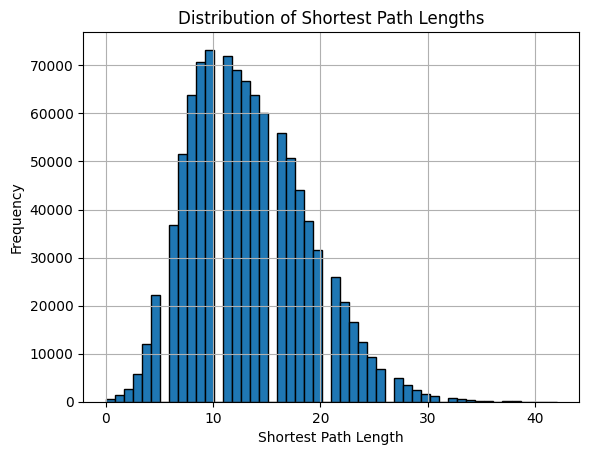

In [16]:
# Repeat one million times with a loading bar
shortest_path_lengths = []
with tqdm(total=1000000) as pbar:  # Initialize the progress bar
    for _ in range(1000000):
        # Choose two random nodes
        node_a = random.choice(list(G1.nodes()))
        node_b = random.choice(list(G1.nodes()))

        # Compute shortest path length between the chosen nodes
        shortest_path_length = nx.shortest_path_length(G1, source=node_a, target=node_b)
        shortest_path_lengths.append(shortest_path_length)

        # Update the progress bar
        pbar.update(1)

# Plot histogram
plt.hist(shortest_path_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Shortest Path Lengths')
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Problem 2

In [63]:
def from_shortest_path_to_graph(lst, G):
    G_sp = nx.Graph()
    for i in range(1, len(lst)):
        u = lst[i-1]
        v = lst[i]
        G_sp.add_edge(u, v, weight = G[u][v]['weight'])
    return G_sp

In [64]:
def pairing(odd_nodes, G):
    #no need to handle len(odd_nodes) = 1 mod 2 cuz the number of odd nodes cannot be odd
    np.random.shuffle(odd_nodes)
    pairs = [odd_nodes[i:i+2] for i in range(0, len(odd_nodes), 2)]
    matching = nx.MultiGraph()
    for i in range(len(pairs)):
      node_a = pairs[i][0]
      node_b = pairs[i][1]
      shortest_path = nx.shortest_path(G, source=node_a, target=node_b)
      shortest_path_G = from_shortest_path_to_graph(shortest_path, G)
      matching.add_edges_from((u, v, data) for u, v, data in shortest_path_G.edges(data=True))
    return matching

In [65]:
def _shortcutting(circuit):
    """
    Remove duplicate nodes in the path
    """
    nodes = []
    for u, v in circuit:
        if v in nodes:
            continue
        if not nodes:
            nodes.append(u)
        nodes.append(v)
    nodes.append(nodes[0])
    return nodes

In [72]:
def min_cost_node_tour(G, trials = 1):
    nodes = list(G.nodes)
    dist = {}
    path = {}
    for n, (d, p) in nx.all_pairs_dijkstra(G):
        dist[n] = d
        path[n] = p
    GG = nx.Graph()
    for u in nodes:
        for v in nodes:
            if u == v:
                continue
            GG.add_edge(u, v, weight=dist[u][v])

    mst = nx.minimum_spanning_tree(GG)
    odd_nodes = [node for node, degree in mst.degree() if degree % 2 == 1]

    best_cost = float('inf')
    best_tour = None

    for _ in tqdm(range(trials)):
        MG = nx.MultiGraph()
        MG.add_edges_from(mst.edges)
        matching = pairing(odd_nodes, GG)
        MG.add_edges_from(matching.edges)
        try:
            tour = _shortcutting(nx.eulerian_circuit(MG))
        except nx.NetworkXError:
            continue
        else:
            cost = sum(GG[u][v]['weight'] for u, v in zip(tour, tour[1:]))
            if cost < best_cost:
              best_cost = cost
              best_tour = tour

    best_path = []
    for i in range(len(best_tour)-1):
        best_path.extend(path[best_tour[i]][best_tour[i+1]][:-1])
    best_path.append(best_tour[-1])
    return best_cost, best_tour

In [73]:
best_cost, best_tour = min_cost_node_tour(G1, 1)
print("Best cost:", best_cost)
print("Best tour:", best_tour)

100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Best cost: 44936.728377602565
Best tour: [123, 5420, 5439, 5435, 5433, 3518, 8051, 8049, 7977, 7976, 4897, 4895, 4894, 4793, 4782, 4781, 4776, 4718, 4727, 3627, 4753, 4955, 4959, 4965, 4971, 4973, 4977, 8134, 4074, 4088, 4104, 8136, 8135, 8162, 8157, 8163, 8164, 4340, 4357, 3510, 4293, 6720, 6726, 6729, 6727, 7982, 7985, 7997, 8000, 3564, 75578, 6202, 6207, 6213, 6221, 6226, 6225, 6228, 8748, 6559, 6558, 6560, 8264, 8265, 8266, 8271, 5719, 5720, 5721, 5724, 5725, 3618, 7647, 3602, 8225, 8304, 8318, 8323, 8322, 8321, 8333, 8328, 8327, 4040, 4021, 4037, 4039, 4035, 4027, 4014, 4002, 3996, 3986, 8361, 8358, 8359, 8372, 8371, 8370, 8406, 8403, 8402, 8398, 8419, 8408, 8416, 8409, 8348, 8349, 8350, 8351, 8366, 8352, 6948, 6943, 6939, 7548, 7541, 77626, 6232, 6236, 6241, 6244, 6249, 8410, 8411, 8288, 8306, 8773, 3917, 3933, 3909, 3931, 3926, 3897, 3901, 5744, 5743, 3597, 7760, 6666, 6665, 6673, 6674, 6679, 6676, 6409, 6411, 3551, 6410, 6412, 6399, 6400, 6401, 4673, 6701, 6699, 6705, 7739, 833

## Problem 3 & 4

In [74]:
best_cost, best_tour = min_cost_node_tour(G1, 1000)
print("Best cost:", best_cost)
print("Best tour:", best_tour)

100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]


Best cost: 37721.42507020213
Best tour: [123, 6147, 6152, 6157, 6163, 6167, 6171, 6175, 6179, 6183, 6191, 6195, 6200, 6218, 6220, 6192, 6186, 6184, 6190, 6196, 6194, 3722, 3745, 5157, 5169, 5171, 5175, 5173, 5148, 6248, 6242, 6238, 6234, 6235, 6233, 4776, 4718, 4727, 3627, 4753, 6741, 6742, 6737, 5455, 5454, 5453, 7158, 7157, 7143, 7100, 7106, 7108, 6819, 3505, 6817, 6827, 6782, 6781, 6778, 6777, 6775, 6774, 6866, 6871, 6884, 6879, 6880, 6905, 6890, 6251, 6244, 6345, 6355, 6352, 6359, 6406, 6350, 6160, 6165, 6169, 6178, 6189, 6193, 9829, 7541, 7548, 6953, 6968, 6980, 7019, 6907, 6904, 6901, 7229, 7348, 7240, 6897, 6841, 6824, 7604, 8864, 6100, 6102, 3718, 3528, 6810, 3524, 6825, 6834, 6823, 6821, 6836, 6839, 6844, 6845, 7225, 7226, 6898, 6900, 7228, 7227, 7221, 7214, 7205, 7196, 7193, 7191, 7045, 7042, 6933, 6948, 6943, 6939, 7681, 7687, 6283, 3628, 5109, 5125, 5126, 5120, 4903, 4795, 5086, 5080, 8033, 3558, 5131, 5137, 5141, 4825, 4829, 7790, 7789, 5942, 5940, 5928, 6130, 6134, 6136, 